# Multilayer Perceptrion (MLP)

The objective of the program is to utilize 2 layers, each one a linear transformations of the form \\
$T: \mathbf{y} = \mathbf{X}\mathbf{w}+\mathbf{b}$ \\
to recognize numbers from images.

# Google Colab 
Suggested tool. \\
Ready to work, no instalation, no extra work, notebook.
Do not know how to insert figures yet...

# MNIST dataset

![texto alternativo](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png) \\
Source: https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png \\

Greyscale 28x28 pixels (values from 0 to 255) \\
60,000 training pairs, labeled from 0 to 9 \\
10,000 testing pairs \\


In [25]:
# Importing libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt


train_data elements: 60000
test_data elements: 10000


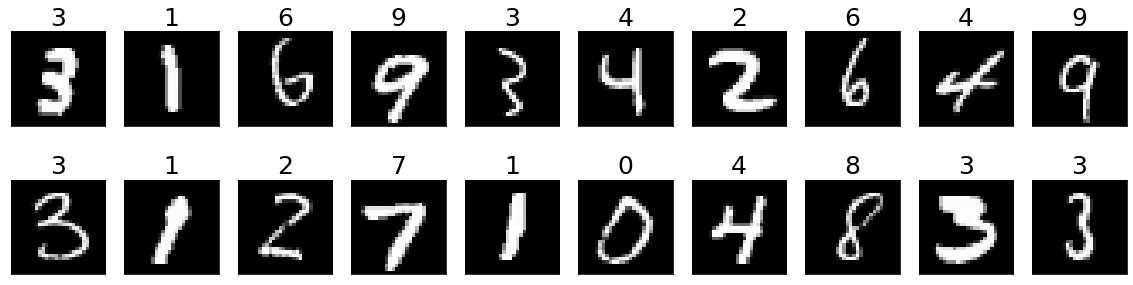

In [26]:
# Loading and transforming the data into Pytorch tensors
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
# According to M. H. Burle, the mean and standard deviation of the MNIST training data are 0.1307 and 0.3081 respectively, hence these values

train_data = datasets.MNIST('',train=True, download=True, transform=transform)
test_data = datasets.MNIST('',train=False, download=True, transform=transform)

print(f"train_data elements: {len(train_data)}")
print(f"test_data elements: {len(test_data)}")

# DataLoaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
dataiter = iter(train_loader)
batchimg, batchlabel = dataiter.next()

batchplot = plt.figure(figsize=(20, 5))
for i in torch.arange(20):
    sub = batchplot.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    sub.imshow(torch.squeeze(batchimg[i]), cmap='gray')
    sub.set_title(str(batchlabel[i].item()), fontsize=25)

# NN structure

Two hidden layers

https://drive.google.com/file/d/1bjzN-nEp0Jcx5vdyRVozLlmDXwptWd4p/view?usp=sharing

784 pixels $\xrightarrow{T_1}$ M neurons $\xrightarrow{T_1}$ 10 neurons

In Gonzalo's example we were using SGD to find the weights in \\
$T: \mathbf{y} = \mathbf{X}\mathbf{w}+\mathbf{b}$ \\
Here, we do that twice




In [27]:
# class torch.nn.Module
# is the "Base class for all neural network modules"
# This is how we defin the network architecture

class Net(nn.Module): 
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(784,128) # fully connected
    self.fc2 = nn.Linear(128,10) # 128 is arbitrary
  def forward(self, x):
    x = torch.flatten(x,1) #transforms a square, cube, etc into a line
    x = self.fc1(x) # fully connected
    x = F.relu(x)   # activation function
    x = self.fc2(x) # fully connected
    output = F.log_softmax(x, dim=1) #threshold ?
    return output

model = Net()

# Implementation

We will define the training and testing processes as functions so we can call them iteratively.

In [28]:
# Optimizer  
#optimizer = optim.SGD([w_hat, b_hat], lr=alpha) # Holds current state of parameters and updates based on gradients.
optimizer = optim.Adadelta(model.parameters(),lr=1.0)
optimizer.zero_grad()                                         # Set the gradients to zero.   
optimizer.step() 

# Training function
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
# Testing function 
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))


# Main program

In [29]:
epochs = 3
torch.manual_seed(1)
device = torch.device('cpu')

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)

model = Net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.316140
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.872084
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.474214
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.456610
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.334980
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.333797
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.189549
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.301503
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.596658
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.207870
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.240116
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.405099
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.297655
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.148928
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.224455
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.124125
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.222931
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.155021
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.457864
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.249751
Train Epoch: 1 [12800/60000 (